## Iceburg or Boat?

In [1]:
import numpy as np
import pandas as pd
import os
import keras

from skimage.util.montage import montage2d
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#path = r"/Users/nicapotato/Google Drive/Learning/Jupyter/Data/Icebergs"
path = r"D:\My Computer\DATA\Icebergs"
os.chdir(path)

In [67]:
def write_model(model, modelname):
    preds = model.predict(test_images, verbose=0)
    sub = pd.DataFrame(preds)
    # Set column names to those generated by the one-hot encoding earlier
    #col_names = one_hot.columns.values
    sub.columns = ['is_iceberg']
    # Insert the column id from the sample_submission at the start of the data frame
    sub.index = test_df['id']
    sub.to_csv("{}.csv".format(modelname), index=True)
    print(sub.head())

Alternate Pre-Processing:

Could perhaps normalize the data
- https://www.kaggle.com/ezietsman/simple-keras-convnet

In [9]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).sque eze()
    return out_df, out_images

train_df, train_images = load_and_format('train.json')
print('training', train_df.shape, 'loaded', train_images.shape)
test_df, test_images = load_and_format('test.json')
print('testing', test_df.shape, 'loaded', test_images.shape)
train_df.sample(3)

training (1604, 5) loaded (1604, 75, 75, 2)
testing (8424, 4) loaded (8424, 75, 75, 2)


,band_1,band_2,id,inc_angle,is_iceberg
1118,"[-20.427303, -21.949158, -23.135489, -21.41181...","[-27.432262, -26.143154, -26.448004, -30.28576...",6b3e62d4,40.3726,1
741,"[-26.383417, -27.051933, -27.051971, -26.06764...","[-26.383417, -23.646698, -26.06761, -29.435738...",a44f95c2,na,0
374,"[-22.158859, -23.11438, -27.484348, -25.956648...","[-24.188013, -24.6577, -24.902454, -25.154303,...",e22c3951,36.7033,0


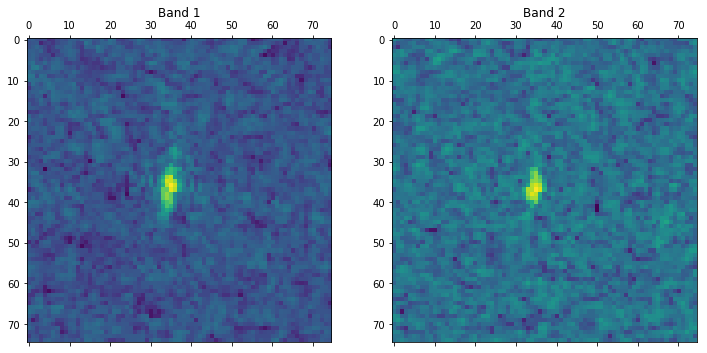

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
# Set image base
ax1.matshow(train_images[0,:,:,0]) #image 0 band 1 (0)
ax1.set_title('Band 1')
ax2.matshow(train_images[0,:,:,1]) #image0, band 2 (1)
ax2.set_title('Band 2')

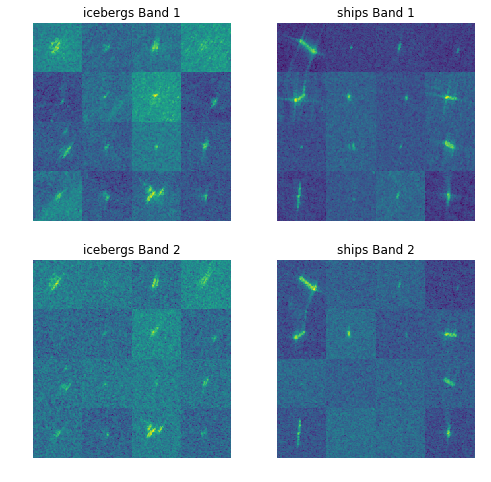

In [11]:
fig, (ax1s, ax2s) = plt.subplots(2,2, figsize = (8,8))
obj_list = dict(ships = train_df.query('is_iceberg==0').sample(16).index,
     icebergs = train_df.query('is_iceberg==1').sample(16).index)
for ax1, ax2, (obj_type, idx_list) in zip(ax1s, ax2s, obj_list.items()):
    ax1.imshow(montage2d(train_images[idx_list,:,:,0]))
    ax1.set_title('%s Band 1' % obj_type)
    ax1.axis('off')
    ax2.imshow(montage2d(train_images[idx_list,:,:,1]))
    ax2.set_title('%s Band 2' % obj_type)
    ax2.axis('off')

In [14]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
train_test_split(train_images, train_df.is_iceberg,
                 test_size=0.20, random_state=1)

num_classes = len(np.unique(y_train)) # number of classes
img_size = 75

print("Number of training samples: %d"%X_train.shape[0])
print( "Number of test samples: %d"%test_df.shape[0])
print("Image rows: %d"%X_train.shape[1])
print("Image columns: %d"%X_train.shape[2])
print("Number of classes: %d"%num_classes)

for i in (X_train, X_valid, y_train, y_valid):
    print("shape {}".format(i.shape))
del train_images, train_df

Number of training samples: 1283
Number of test samples: 8424
Image rows: 75
Image columns: 75
Number of classes: 2
shape (1283, 75, 75, 2)
shape (321, 75, 75, 2)
shape (1283,)
shape (321,)


In [23]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
import datetime
import time

#tensorboard --logdir=models:"D:\My Computer\DATA\Icebergs\logs\"

In [69]:
## Add "Same" padding
model=Sequential()
model.add(Conv2D(filters= 16, kernel_size=(3, 3), activation='relu',
                input_shape=(img_size, img_size, 2)))
model.add(MaxPooling2D(pool_size=2))#, strides=2, padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(filters= 32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=3))#, strides=2, padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(filters= 64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.5))
# model.add(Conv2D(filters= 64, kernel_size=5, activation='relu'))
# model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))
# model.add(Conv2D(filters= 32, kernel_size=5, activation='relu'))
# model.add(MaxPooling2D(pool_size=3, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy',
          metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 73, 73, 16)        304       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 32)        4640      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 9, 9, 64)          18496     
__________

In [70]:
start = time.time()
model.fit(X_train, y_train,
       validation_data=(X_valid, y_valid),
       batch_size = 32, epochs = 100, verbose=2, callbacks=[
              keras.callbacks.TensorBoard(log_dir="./logs/{}".format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H_%M_%S')),
                    histogram_freq=0, write_graph=False, write_images=False),
              keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=.05, patience=20,
                    verbose=0, mode='auto')])
end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

Train on 1283 samples, validate on 321 samples
Epoch 1/100
0s - loss: 8.1734 - acc: 0.4638 - val_loss: 4.2463 - val_acc: 0.5202
Epoch 2/100
0s - loss: 7.5127 - acc: 0.5199 - val_loss: 7.7327 - val_acc: 0.5202
Epoch 3/100
0s - loss: 7.5291 - acc: 0.5284 - val_loss: 7.7327 - val_acc: 0.5202
Epoch 4/100
0s - loss: 7.5334 - acc: 0.5323 - val_loss: 7.7327 - val_acc: 0.5202
Epoch 5/100
0s - loss: 7.5246 - acc: 0.5331 - val_loss: 7.7327 - val_acc: 0.5202
Epoch 6/100
0s - loss: 7.4912 - acc: 0.5339 - val_loss: 7.7327 - val_acc: 0.5202
Epoch 7/100
0s - loss: 7.5261 - acc: 0.5284 - val_loss: 7.7327 - val_acc: 0.5202
Epoch 8/100
0s - loss: 7.3371 - acc: 0.5175 - val_loss: 0.8717 - val_acc: 0.5202
Epoch 9/100
0s - loss: 1.1469 - acc: 0.5573 - val_loss: 0.6264 - val_acc: 0.6449
Epoch 10/100
0s - loss: 0.5899 - acc: 0.6625 - val_loss: 0.6136 - val_acc: 0.6885
Epoch 11/100
0s - loss: 0.5589 - acc: 0.6820 - val_loss: 0.5861 - val_acc: 0.6947
Epoch 12/100
0s - loss: 0.5457 - acc: 0.6952 - val_loss: 0.5

In [71]:
write_model(model, "Cnn1")

            is_iceberg
id                    
5941774d  7.552902e-01
4023181e  6.378611e-01
b20200e4  3.002832e-07
e7f018bb  7.198746e-01
4371c8c3  5.043544e-01


In [52]:
model.save('model.h5')